# Анализ тарифов Сотовой компании

В нашем распоряжении данные 500 пользователей Оператора: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. Клиентам предлагается два тарифных плана: «Смарт» и «Ультра».

**Цель исследования** 

Необходимо сделать предварительный анализ тарифов и проверить гипотезы на небольшой выборке клиентов, чтобы понять, какой тариф приносит больше денег. Результаты исследования будут переданы в коммерческий департамент, чтобы скорректировать рекламный бюджет.

Проверка гипотез:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Ход исследования**

Входные данные — архив данных компании. О качестве данных ничего не известно. Поэтому перед нашим исследованием понадобится обзор данных. Необходимо проверить данные на ошибки и оценить их влияние. Затем, на этапе предобработки нужно поискать возможность исправить самые критичные ошибки и подготовить данные к анализу. 

Таким образом, исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Исследование данных.
 4. Проверка гипотез.

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

**Примечание:**
Оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Обзор данных

### Открытие файлов. Общее предоставление

Импортируем библиотеки для работы в Питоне.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import levene

Нам предоставили 5 файлов с записями о самих клиентах, их звонках, пользованием интернета, сообщениях, тарифах. Откроем эти таблицы и изучим общую информацию о данных. Прочитаем файлы и сохраним их в переменных `u, calls, i, m, t` соответственно.

Изучим информацию о клиентах.

In [ ]:
u = pd.read_csv('users.csv') 
u.head() 

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


**Описание данных.**

Согласно документации к данным:

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

In [ ]:
u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В предоставленном файле информация о 500 клиентах. Столбец `churn_date` — дата прекращения пользования тарифом, заполнено только для 38 случаев, если значение пропущено, то тариф ещё действовал на момент выгрузки данных.

Подробнее изучим распределение значений методом `describe()`, а также найдем количество явных дубликатов - `duplicated().sum()`.

In [ ]:
print('Количество явных дубликатов:', u.duplicated().sum())

Количество явных дубликатов: 0


In [ ]:
# distribution of data values
u.describe() 

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Отрицательные значения отсутствуют. Средний возраст клиента 46 лет. Разница медианы и среднего значения составляет всего полгода, что говорит о минимальных выбросах в данных.

In [ ]:
u['tariff'].value_counts() 

smart    351
ultra    149
Name: tariff, dtype: int64

In [ ]:
# share of clients 'smart'
share_smart = u[u['tariff']=='smart']['tariff'].copy()
share_smart = share_smart.shape[0] / u.shape[0]
print(f'Доля клиентов Смарт составляет {share_smart:.1%}')

Доля клиентов Смарт составляет 70.2%


Клиенты в основном подключены к тарифу "Смарт".

Теперь откроем файл `calls.csv`.

In [ ]:
calls = pd.read_csv('calls.csv') 
calls.head() 

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


**Описание данных.**

Согласно документации к данным:

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В предоставленном файле регистрация 202607 звонков. Столбец `call_date` - дата звонка, переведем эти данные в формат месяца в разделе 2. Столбец `duration` - длительность звонка тип `float`, округлим эти данные до большего целого в разделе 2. 

Подробнее изучим распределение значений методом `describe()`, а также найдем количество явных дубликатов - `duplicated().sum()`.

In [ ]:
print('Количество явных дубликатов:', calls.duplicated().sum())

Количество явных дубликатов: 0


In [ ]:
# distribution of data values
calls.describe() 

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Отрицательные значения отсутствуют. Звонок в среднем длился 6.8 минут. Разница медианы и среднего значения составляет всего 0.8 минуты, что говорит о минимальных выбросах в данных. Максимальное значение 38 минут похоже на выброс - аномальное значение. Имеются звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

Теперь откроем файл `internet.csv`.

In [ ]:
i = pd.read_csv('internet.csv') 
i.head() 

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


**Описание данных.**

Согласно документации к данным:

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [ ]:
i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В предоставленном файле регистрация 149396 случаев использования интернет-трафика. Столбец `session_date` - дата сессии, переведем эти данные в формат месяца в разделе 2. Столбец `mb_used` - объем потраченного трафика в мегабайтах тип `float`, округлим эти данные до большего целого и переведем в гигабайты в разделе 2. Столбец `Unnamed: 0` дублирует индекс датасета - это лишняя информация, можем его удалить.

Подробнее изучим распределение значений методом `describe()`, а также найдем количество явных дубликатов - `duplicated().sum()`.

In [ ]:
print('Количество явных дубликатов:', i.duplicated().sum())

Количество явных дубликатов: 0


In [ ]:
# remove column 'Unnamed: 0'
i = i.drop(columns = 'Unnamed: 0',  axis=1) 

# distribution of data values
i.describe() 

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


Отрицательные значения отсутствуют. Сессия среднего пользователя использует 370 Мб. Разница медианы и среднего значения составляет 22 Мб, что говорит о выбросах в данных. Максимальное значение 1724.83 Мб похоже на выброс - уникальное значение. Имеются сессии с нулевым трафиком, обозначим их как пропуски для заполнения (см. раздел 2).

Теперь откроем файл `messages.csv`.

In [ ]:
m = pd.read_csv('messages.csv') 
m.head() 

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


**Описание данных.**

Согласно документации к данным:

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [ ]:
m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В предоставленном файле регистрация 123036 сообщений. Столбец `message_date` - дата сообщения, переведем эти данные в формат месяца в разделе 2. Найдем количество явных дубликатов - `duplicated().sum()`.

In [ ]:
print('Количество явных дубликатов:', m.duplicated().sum())

Количество явных дубликатов: 0


Теперь откроем файл `tariffs.csv`.

In [ ]:
t = pd.read_csv('tariffs.csv') 
t

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Описание данных.**

Согласно документации к данным:

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Необходимо перевести Мб в Гб. Сделаем это преобразование в разделе 2.

### Вывод

Мы получили общее представление о данных. В выборке имеется информация о 500 клиентах за 2018 год: архив звонков, сообщений и интернет сессий, а также общие данные о пользователях и тарифах. Клиенты в основном подключены к тарифу "Смарт", доля составляет 70.2%. 

В данных были обнаружены проблемы. Некоторые из них необходимо преобразовать, чтобы привести информацию в форму более удобную для анализа:

- Столбец "churn_date" содержит пропуски. На исследование не влияет, можем оставить.
- Даты в столбцах переведем в формат месяца.
- Нулевые значения для звонков и интернет сессий можем оставить. Это либо пропущенные звонки, либо сессия с нулевым интернет-трафиком.
- Значения длительности звонков округлить до целых в большую сторону.
- Столбец "Unnamed: 0" был удален, как дублирующий.
- Значения интернет-трафика округлить до целых в большую сторону. 
- Перевести мегабайты в гигабайты.

## Предобработка данных

### Клиенты

Информация в таблице избыточна, не все данные нужны нам для анализа. Перенесем данные столбцов `user_id, city, tariff` в новую таблицу.

In [ ]:
# copy of data 'user_id', 'city', 'tariff'
ua = u[['user_id', 'city', 'tariff']].copy() 
ua.head()

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


### Сообщения

Информация в таблице требует доработки. Добавим указание месяца для каждой строки с помощью метода `DatetimeIndex`. Соберем данные в сводную таблицу с группировкой по месяцам и пользователям для определения количества сообщений. 

In [ ]:
# set month for dates
m['month'] = pd.DatetimeIndex(m['message_date']).month 

# pivot table for data of messages
ma = m.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')

# change the column name
ma.columns = ['sms_count'] 

# reset multi-index
ma = ma.reset_index() 
ma.head()

,user_id,month,sms_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Звонки

«Мегалайн» всегда округляет секунды до минут. Округлим в данных продолжительность звонков до большего целого. Результат запишем в новый столбец. Воспользуемся методом `ceil` из библиотеки `numpy`.

In [ ]:
# round of calls duration to the nearest greater integer
calls['dur_round'] = calls['duration'].apply(np.ceil) 
calls.head()

,id,call_date,duration,user_id,dur_round
0,1000_0,2018-07-25,0.00,1000,0.0
1,1000_1,2018-08-17,0.00,1000,0.0
2,1000_2,2018-06-11,2.85,1000,3.0
3,1000_3,2018-09-21,13.80,1000,14.0
4,1000_4,2018-12-15,5.18,1000,6.0


Информация в таблице требует доработки. Добавим указание месяца для каждой строки с помощью метода `DatetimeIndex`. Соберем данные в сводную таблицу с группировкой по месяцам и пользователям для определения количества и длительности звонков. 

In [ ]:
# set month for dates
calls['month'] = pd.DatetimeIndex(calls['call_date']).month 

# pivot table for data of calls
ca = calls.pivot_table(index=['user_id', 'month'], values='dur_round', 
                       aggfunc=['sum','count']) 

# change the column name
ca.columns = ['calls_sum', 'calls_count'] 

# reset multi-index
ca = ca.reset_index() 
ca.head()

,user_id,month,calls_sum,calls_count
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


### Интернет

Информация в таблице требует доработки. «Мегалайн» всегда округляет общую сумму за месяц в бо́льшую сторону. Округлим в данных количество трафика до большего целого. Воспользуемся методом `ceil` из библиотеки `numpy`. Добавим указание месяца для каждой строки с помощью метода `DatetimeIndex`. Соберем данные в сводную таблицу с группировкой по месяцам и пользователям для определения количества трафика. 

In [ ]:
# round of mb_used to the nearest greater integer
i['mb_used_round'] = i['mb_used'].apply(np.ceil) 

# set month for dates
i['month'] = pd.DatetimeIndex(i['session_date']).month 

# pivot table for data of web-traffic
ia = i.pivot_table(index=['user_id', 'month'], values='mb_used_round', 
                   aggfunc='sum')

# change the column name
ia.columns = ['mb_sum'] 

# reset multi-index
ia = ia.reset_index() 
ia.head()

,user_id,month,mb_sum
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0


Тарифы используют значения трафика в гигабайтах для расчета стоимости. Переведем мегабайты соответственно, результат запишем в новый столбец.

In [ ]:
# transfer Mb to Gb
ia['gb_used'] = ia['mb_sum']/1024 
ia.head()

,user_id,month,mb_sum,gb_used
0,1000,5,2256.0,2.203125
1,1000,6,23257.0,22.711914
2,1000,7,14016.0,13.687500
3,1000,8,14070.0,13.740234
4,1000,9,14581.0,14.239258


Округлим в данных количество трафика до большего целого. Удалим столбец `mb_sum`.

In [ ]:
# round of gb_used to the nearest greater integer
ia['gb_used'] = ia['gb_used'].apply(np.ceil) 
ia = ia.drop(columns = 'mb_sum',axis = 1)
ia.head()

,user_id,month,gb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


### Тариф

Тарифы используют значения трафика в гигабайтах для расчета стоимости. Запишем новый столбец для Гб.

In [ ]:
t['gb_incl'] = t['mb_per_month_included']/1024

Информация в таблице избыточна, не все данные нужны нам для анализа. Удалим столбец `mb_per_month_included`. Запишем названия столбцов более кратко.

In [ ]:
# remove column
t = t.drop(columns = 'mb_per_month_included',axis = 1) 

# change columns name
t.columns = ['sms_incl', 'minut_incl', 'rub_fee',
       'rub_gb', 'rub_sms', 'rub_minut', 'tariff',
       'gb_incl']
t

,sms_incl,minut_incl,rub_fee,rub_gb,rub_sms,rub_minut,tariff,gb_incl
0,50,500,550,200,3,3,smart,15.0
1,1000,3000,1950,150,1,1,ultra,30.0


### Общие данные

Соберем все данные о клиентах в общий датасет `df`. Воспользуемся методом `merge` для объединения данных. Сводные таблицы звонков, сообщений и трафика пользователей объединим по столбцам `user_id, month`.

In [ ]:
# merge data of calls with sms and web-traffic
df = ma.merge(ca, on=['user_id', 'month'], how='outer')
df = df.merge(ia, on=['user_id', 'month'], how='outer')

Присоединим информацию о клиентах и тарифе. Объединим общие данные по столбцам `user_id, tariff` соответственно.

In [ ]:
# merge data of clients and tariff
df = df.merge(ua, on='user_id')
df = df.merge(t, on='tariff')

df.head()

,user_id,month,sms_count,calls_sum,calls_count,gb_used,city,tariff,sms_incl,minut_incl,rub_fee,rub_gb,rub_sms,rub_minut,gb_incl
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,3000,1950,150,1,1,30.0
1,1000,6,60.0,172.0,43.0,23.0,Краснодар,ultra,1000,3000,1950,150,1,1,30.0
2,1000,7,75.0,340.0,47.0,14.0,Краснодар,ultra,1000,3000,1950,150,1,1,30.0
3,1000,8,81.0,408.0,52.0,14.0,Краснодар,ultra,1000,3000,1950,150,1,1,30.0
4,1000,9,57.0,466.0,58.0,15.0,Краснодар,ultra,1000,3000,1950,150,1,1,30.0


Проверим, сколько пользователей представлено в результирующей таблице и какие пропущены.

In [ ]:
len(df['user_id'].unique())

498

In [ ]:
u.query('user_id not in @df.user_id')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Обратим внимание, что таблица представлена только для 498 клиентов из 500. В предоставленной выборке не было информации о клиентах с user_id 1128 и 1371. Клиенты, отсутствующие в итоговой таблице, даже не пользовались тарифными планами, о чем свидетельствует подключение и отключение тарифных планов в один месяц. Отсутствие этих данных не повлияет на анализ.

Выведем информацию о полученном df.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      3214 non-null   int64  
 1   month        3214 non-null   int64  
 2   sms_count    2717 non-null   float64
 3   calls_sum    3174 non-null   float64
 4   calls_count  3174 non-null   float64
 5   gb_used      3203 non-null   float64
 6   city         3214 non-null   object 
 7   tariff       3214 non-null   object 
 8   sms_incl     3214 non-null   int64  
 9   minut_incl   3214 non-null   int64  
 10  rub_fee      3214 non-null   int64  
 11  rub_gb       3214 non-null   int64  
 12  rub_sms      3214 non-null   int64  
 13  rub_minut    3214 non-null   int64  
 14  gb_incl      3214 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 401.8+ KB


В результирующей таблице появились пропущенные значения. Пользователи не всегда одновременно пользовались всеми услугами мобильного оператора. Оставлять пропуски тоже не очень удобно, значения `NaN` могут технически помешать выполнению методов в Python. Выполним замену в этих столбцах на "0", это будет логично. Округлим данные в столбцах `'sms_count', 'calls_sum', 'calls_count', 'gb_used', 'gb_incl'` до целых.

In [ ]:
# filling NaN with "0"
df = df.fillna(0) 

# list of columns are transfered to integer
columns_int = ['sms_count', 'calls_sum', 'calls_count', 'gb_used', 'gb_incl']

# transfer to integer
df[columns_int] = df[columns_int].astype(int) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      3214 non-null   int64 
 1   month        3214 non-null   int64 
 2   sms_count    3214 non-null   int64 
 3   calls_sum    3214 non-null   int64 
 4   calls_count  3214 non-null   int64 
 5   gb_used      3214 non-null   int64 
 6   city         3214 non-null   object
 7   tariff       3214 non-null   object
 8   sms_incl     3214 non-null   int64 
 9   minut_incl   3214 non-null   int64 
 10  rub_fee      3214 non-null   int64 
 11  rub_gb       3214 non-null   int64 
 12  rub_sms      3214 non-null   int64 
 13  rub_minut    3214 non-null   int64 
 14  gb_incl      3214 non-null   int64 
dtypes: int64(13), object(2)
memory usage: 401.8+ KB


Пропуски в данных отсутствуют.

### Помесячная выручка

Посчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану). Функция `profit` выполнит эти расчеты для каждой строки. Запишем результат в новый столбец.

In [ ]:
# function of profit calculation
def profit(row):
    
    sms = row['sms_incl']-row['sms_count']
    calls = row['minut_incl']-row['calls_sum']
    traffic = row['gb_incl']-row['gb_used']
    profit_sms = 0
    profit_calls = 0
    profit_traffic = 0
    
    if sms < 0:
        profit_sms = abs(sms)*row['rub_sms']
    if calls < 0:
        profit_calls = abs(calls)*row['rub_minut']
    if traffic < 0:
        profit_traffic = abs(traffic)*row['rub_gb']
    profit = row['rub_fee'] + profit_sms + profit_calls + profit_traffic
    
    return profit

In [ ]:
# apply function into new column 'profit'
df['profit'] = df.apply(profit, axis=1) 

df.head()

,user_id,month,sms_count,calls_sum,calls_count,gb_used,city,tariff,sms_incl,minut_incl,rub_fee,rub_gb,rub_sms,rub_minut,gb_incl,profit
0,1000,5,22,159,22,3,Краснодар,ultra,1000,3000,1950,150,1,1,30,1950
1,1000,6,60,172,43,23,Краснодар,ultra,1000,3000,1950,150,1,1,30,1950
2,1000,7,75,340,47,14,Краснодар,ultra,1000,3000,1950,150,1,1,30,1950
3,1000,8,81,408,52,14,Краснодар,ultra,1000,3000,1950,150,1,1,30,1950
4,1000,9,57,466,58,15,Краснодар,ultra,1000,3000,1950,150,1,1,30,1950


Посмотрим какие значения принимает столбец profit для разных тарифов.

In [ ]:
# describe values of Ultra profit
df.query('tariff=="ultra"')['profit'].describe()

count     985.000000
mean     2071.065990
std       378.802377
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: profit, dtype: float64

In [ ]:
# describe values of Smart profit
df.query('tariff=="smart"')['profit'].describe()

count    2229.000000
mean     1294.639300
std       820.933202
min       550.000000
25%       550.000000
50%      1038.000000
75%      1750.000000
max      6770.000000
Name: profit, dtype: float64

Некоторые пользователи перерасходовали лимиты по тарифу и заплатили сумму больше абонентской платы. Пользователи Смарт, в общем случае, переплачивают (медиана - 1038 руб), пользователи Ультра остаются в пределах абонентской платы (медиана - 1950 руб).

### Вывод

Полученные датасеты содержали избыточную информацию, мы взяли только те особенности клиентов, которые могли повлиять на наше исследование. На этапе подготовки данных были выполнены следующие шаги:
- даты перевели в формат месяца;
- значения в минутах округлили до большего целого;
- объем интернет-трафика округлили до большего целого и перевели в гигабайты;
- была создана сводная таблица с данными каждого пользователя, где отражено помесячно количество и длительность звонков, объем интернет-трафика и количество сообщений;
- посчитали помесячную выручку с каждого пользователя и добавили результат в таблицу;
- все числовые значения округлили до целых.

Пользователи Смарт, в общем случае, переплачивают (медиана - 1038 руб), пользователи Ультра остаются в пределах абонентской платы (медиана - 1950 руб).

Отметим, что в предоставленной выборке не было информации только для двух клиентов. Отсутствие этих данных не повлияет на анализ.

Итоговая таблица поможет лучше ориентироваться в полученной выборке пользователей и выполнить точнее наше исследование.

## Исследование данных

### Общий анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Выделим стоблцы с данными о минутах разговора, сообщениях, объёмах интернет-трафика и выручки в датасет `df_pivot_month`. Найдем средние значения: сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Добавим также данные по выручке.

In [ ]:
# data for clients communication per month
df_pivot_month = df[['user_id','tariff','calls_sum', 'sms_count', 
                     'gb_used', 'profit' ]].copy()

# pivot_table for tarriff with mean
df_pivot_month.groupby('tariff').mean()

,user_id,calls_sum,sms_count,gb_used,profit
tariff,,,,,
smart,1246.506505,417.934948,33.384029,16.359354,1294.63930
ultra,1263.094416,526.623350,49.363452,19.525888,2071.06599


Рассмотрим полученные данные. Будем ориентироваться на медиану и сделаем анализ значений в общем случае:
- пользователи тарифа Ультра говорят больше, 527 минут против 418 у Смарт;
- пользователи тарифа Ультра пользуется интернетом в большем объеме, 20 Гб против 17 у Смарт;
- пользователи тарифа Ультра отправляют сообщения чаще, 50 смс против 34 у Смарт.
- пользователи тарифа Ультра платят за услуги сотового оператора больше, 2072 руб. против 1295 у Смарт.

Клиенты тарифа Ультра в общем случае чаще пользуются услугами сотового оператора Мегалайн, чем пользователи Смарт. Вероятно, это обусловлено большим лимитом для звонков, смс и объемом интернет-трафика в рамках тарифа Ультра, который редко нарушается. Средний пользователь тарифа Смарт превышает лимит по интернет трафику и платит в среднем дополнительные 400 рублей в месяц за услуги оператора. Но все равно тариф Ультра приносит компании больше денег за счет высокой абонентской платы.

Посчитаем дисперсию и стандартное отклонение для каждого тарифа. Если известно, что датасет — не вся совокупность, а выборка из неё, вместо дисперсии считают её оценку по имеющейся выборке, для этого в методе `var() и std()` указывают параметр `ddof=1`.

In [ ]:
# variance for Ultra
np.var(df_pivot_month.query('tariff=="ultra"'), ddof=1)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


user_id       19795.057133
calls_sum    100873.633397
sms_count      2285.266143
gb_used          97.334949
profit       143491.240560
dtype: float64

In [ ]:
# variance for Smart
np.var(df_pivot_month.query('tariff=="smart"'), ddof=1)

user_id       21350.907161
calls_sum     36219.315784
sms_count       796.812958
gb_used          33.160304
profit       673931.321363
dtype: float64

Дисперсия значений для тарифа Ультра больше, чем у Смарт, кроме дисперсий выручки. Разница значений выручки у тарифа Смарт больше.

In [ ]:
# standard deviation for Ultra
np.std(df_pivot_month.query('tariff=="ultra"'), ddof=1)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


user_id      140.694908
calls_sum    317.606098
sms_count     47.804457
gb_used        9.865848
profit       378.802377
dtype: float64

In [ ]:
# standard deviation for Smart
np.std(df_pivot_month.query('tariff=="smart"'), ddof=1)

user_id      146.119496
calls_sum    190.313730
sms_count     28.227876
gb_used        5.758498
profit       820.933202
dtype: float64

Разница значений выручки у тарифа Смарт также больше. Пользователям тарифа Смарт не всегда получается оставаться в рамках тарифа.

Во всем остальном, что касается минут разговора, сообщений и объёма интернет-трафика, стандартное отклонение для тарифа Ультра больше, чем у Смарт. Вероятно, это также обусловлено высокими лимитами в рамках тарифа, по сравнению со Смарт. Значения в общем случае колеблются около лимита, чем больше лимит - тем больше дисперсия и стандартное отклонение. 

### Гистограммы

Построим гистограммы и диаграммы размаха для звонков, сообщений и объема интернет-трафика в рамках каждого тарифа.

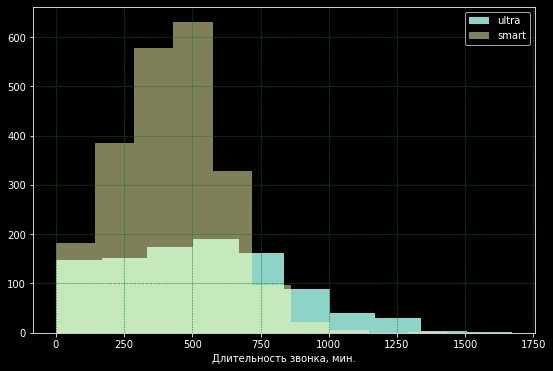

In [ ]:
plt.style.use('dark_background')


# histogram for Ultra calls
df_pivot_month.query('tariff=="ultra"')['calls_sum'].hist(figsize=(9,6))

# histogram for Smart calls
df_pivot_month.query('tariff=="smart"')['calls_sum'].hist(alpha=0.5, 
                                                          figsize=(9,6))

plt.legend(['ultra', 'smart'])
plt.xlabel('Длительность звонка, мин.')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5);

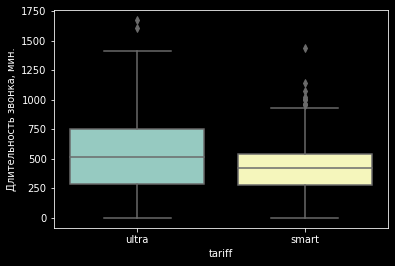

In [ ]:
# boxplot for tariff and calls
sns.boxplot(x="tariff", y="calls_sum", data=df_pivot_month);
plt.ylabel('Длительность звонка, мин.');

Распределение продолжительности звонков у тарифов похожи на нормальное распределение. 

Графики показывают: 
- гистограмма для тарифа Ультра (синий цвет) более сглаженная, что говорит о меньшем количестве выбросов;
- распределение значений для тарифа Смарт находится около тарифного лимита - 500 минут;
- дисперсия и размах значений больше для тарифа Ультра; 
- медиана меньше среднего для тарифа Ультра, что говорит о скошенности вправо в большей степени, чем для тарифа Смарт.

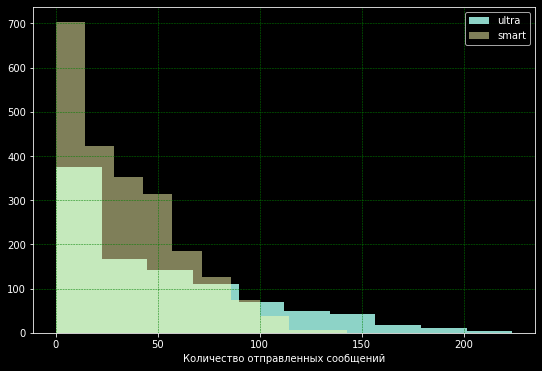

In [ ]:
# histogram for Ultra sms
df_pivot_month.query('tariff=="ultra"')['sms_count'].hist(figsize=(9,6))

# histogram for Smart sms
df_pivot_month.query('tariff=="smart"')['sms_count'].hist(alpha=0.5,
                                                          figsize=(9,6))

plt.legend(['ultra', 'smart'])
plt.xlabel('Количество отправленных сообщений')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5);

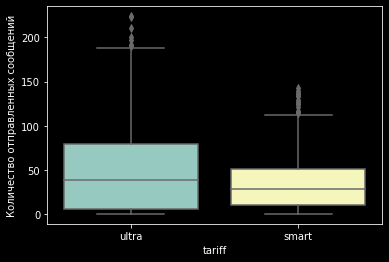

In [ ]:
# boxplot for tariff and sms
sns.boxplot(x="tariff", y="sms_count", data=df_pivot_month);
plt.ylabel('Количество отправленных сообщений');

Графики показывают: 
- гистограмма тарифов имеет пик при нулевом количестве сообщений. Отправка сообщений не так актуальна у пользователей в эпоху социальных сетей и различных мессенджеров;

- дисперсия и размах значений больше для тарифа Ультра; 

- пользователи тарифа Смарт стараются уложиться в лимит 50ти сообщений. Это видно на диаграмме размаха, 75% значений меньше 50.

- медиана у тарифов сильно меньше среднего, что говорит о скошенности вправо для распределения значений.

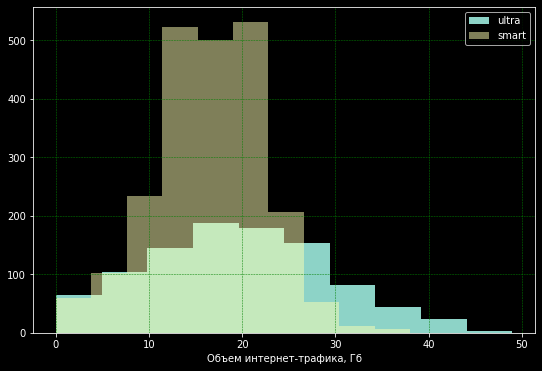

In [ ]:
# histogram for Ultra internet traffic
df_pivot_month.query('tariff=="ultra"')['gb_used'].hist(figsize=(9,6))

# histogram for Smart internet traffic
df_pivot_month.query('tariff=="smart"')['gb_used'].hist(alpha=0.5,
                                                        figsize=(9,6))

plt.legend(['ultra', 'smart'])
plt.xlabel('Объем интернет-трафика, Гб')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5);

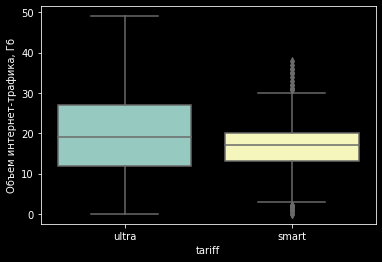

In [ ]:
# boxplot for tariff and internet traffic
sns.boxplot(x="tariff", y="gb_used", data=df_pivot_month);
plt.ylabel('Объем интернет-трафика, Гб');

Распределение объема интернет-трафика у тарифов похожи на нормальное распределение. 

Графики показывают: 
- гистограмма для тарифа Ультра (синий цвет) более сглаженная, что говорит о меньшем количестве выбросов;
- распределение значений для тарифа Смарт находится около тарифного лимита - 15 гигабайт;
- распределение значений для тарифа Ультра находится около тарифного лимита - 20 гигабайт;
- дисперсия и размах значений больше для тарифа Ультра; 
- медиана меньше среднего для тарифа Ультра, что говорит о скошенности вправо в большей степени, чем для тарифа Смарт.

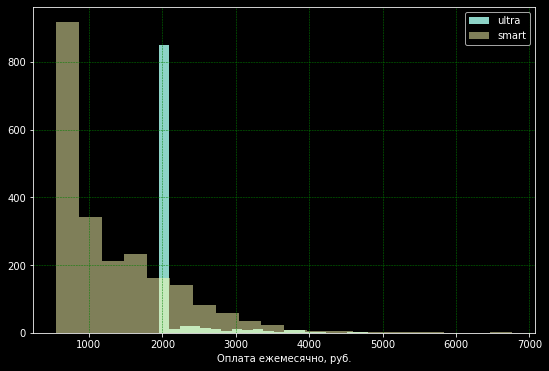

In [ ]:
# histogram for Ultra profit
df_pivot_month.query('tariff=="ultra"')['profit'].hist(bins=20, 
                                                       figsize=(9,6))

# histogram for Smart profit
df_pivot_month.query('tariff=="smart"')['profit'].hist(bins=20, alpha=0.5,
                                                       figsize=(9,6))

plt.legend(['ultra', 'smart'])
plt.xlabel('Оплата ежемесячно, руб.')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5);

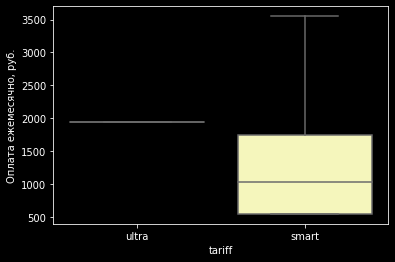

In [ ]:
# boxplot for tariff and profit
sns.boxplot(x="tariff", y="profit", data=df_pivot_month, showfliers=0);
plt.ylabel('Оплата ежемесячно, руб.');

In [ ]:
# distribution of profit values for Smart
df_pivot_month.query('tariff=="smart"')['profit'].describe()

count    2229.000000
mean     1294.639300
std       820.933202
min       550.000000
25%       550.000000
50%      1038.000000
75%      1750.000000
max      6770.000000
Name: profit, dtype: float64

In [ ]:
# distribution of profit values for Ultra
df_pivot_month.query('tariff=="ultra"')['profit'].describe()

count     985.000000
mean     2071.065990
std       378.802377
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: profit, dtype: float64

Графики и распределение значений показывают:
- гистограмма тарифов имеет пик в значениях, соответствующих абонентской плате. Много клиентов старается не превышать лимитов по тарифу;
- медиана у тарифов сильно меньше среднего, что говорит о скошенности вправо для распределения значений.
- дисперсия и размах значений больше для тарифа Смарт;
- большое количество клиентов тарифа Смарт в общем случае платит больше абонентской платы (75% значений распределены до 1750 руб.). При нормальном распределение выручки до 3500 руб. в месяц, имеются аномальные значения оплаты до 6770 руб. Пользователям тарифа тяжело уложиться в тарифный лимит.
- большинство клиентов тарифа Ультра платят только абонентскую плату. Нормальное распределение значений выручки до 1950 руб. в месяц.


### Вывод

Анализ полученной выборки выявил закономерности и определенные результаты:
- пользователи тарифа Ультра говорят больше, 527 минут против 418 у Смарт;
- пользователи тарифа Ультра пользуется интернетом в большем объеме, 20 Гб против 17 у Смарт;
- пользователи тарифа Ультра отправляют сообщения чаще, 50 смс против 34 у Смарт.
- пользователи тарифа Ультра платят за услуги сотового оператора больше, 2072 руб. против 1295 у Смарт.

Визуализация данных на этом этапе также подтверждает полученные результаты, кроме значений по оплате. Клиенты тарифа Ультра чаще пользуются услугами сотового оператора Мегалайн, чем пользователи Смарт. Несмотря на такое поведение клиентов и средние значения выручки, пользователи тарифа Смарт чаще платят больше. Количество выбросов у тарифа Смарт больше, что говорит о выборе пользователей в пользу низкой стоимости абонентской платы. Возможно каким-то клиентам выгоднее перейти на тариф Ультра. 

Пользователи выбирают тариф под свои нужды, но не всегда у них получается оставаться в рамках тарифа. Например, средний пользователь тарифа Смарт превышает лимит по интернет-трафику и платит в среднем дополнительные 400 рублей в месяц за услуги оператора.

## Проверка гипотез

Была получена выборка от Сотовой компании, данные за 2018 год. Мы можем лишь сделать предположение о генеральной совокупности и при условии того, что оно верно, посчитать, насколько вероятно увидеть в выборке полученные значения. Если эта вероятность относительно высока — данные не дают основания отвергнуть это предположение. Если низка — по наблюдаемым данным можно сделать вывод, что, скорее всего, предположение всё-таки неверно (но не опровергнуть его и не доказать обратное).

### Средняя выручка тарифов

Проверим гипотезу - средняя выручка пользователей тарифов Ультра и Смарт различаются. Создадим датасеты для анализа выручки каждого из тарифов.

In [ ]:
# dataset for Smart profit

smart = df.query('tariff=="smart"')['profit'].copy()
smart = smart.reset_index()
smart = smart.drop(columns = ['index'],axis = 1)
display(smart.head())
print('Количество строк', smart.shape[0])

,profit
0,550
1,1150
2,1550
3,950
4,550


Количество строк 2229


In [ ]:
# dataset for Ultra profit

ultra = df.query('tariff=="ultra"')['profit'].copy()
ultra = ultra.reset_index()
ultra = ultra.drop(columns = ['index'],axis = 1)
display(ultra.head())
print('Количество строк', ultra.shape[0])

,profit
0,1950
1,1950
2,1950
3,1950
4,1950


Количество строк 985


Сформулируем нулевую гипотезу: средняя выручка от пользователей тарифов Ультра и Смарт не различается. Альтернативная гипотеза будет звучать противоположно: средняя выручка пользователей тарифов различаются. В исследовании необходимо доказать, что различия в выборке не случайны. 

В Python есть специальный метод `scipy.stats.ttest_ind()` для проверки гипотезы о равенстве среднего двух совокупностей, он выдает значение `p-value`. Выборки по тарифам имеют разный размер, найдем дисперсию для каждого тарифа. Датасеты — не вся совокупность, а выборка из неё, вместо дисперсии считают её оценку по имеющейся выборке, для этого в методе `var()` указываем параметр `ddof=1`.

In [ ]:
# variance for Smart
smart.var(ddof=1)

profit    673931.321363
dtype: float64

In [ ]:
# variance for Ultra
ultra.var(ddof=1)

profit    143491.24056
dtype: float64

Для проверки равны ли дисперсии можно также воспользоваться статистическим тестами Левене. Выполним данные тест.

In [ ]:
st.levene(smart['profit'], ultra['profit'])

LeveneResult(statistic=615.7061337306674, pvalue=1.6855369377883898e-124)

Значение pvalue критически малое и меньше 0.05. Результат вычислений - дисперсии выборок разные. Выполним проверку нулевой гипотезы выручки для совокупностей по тарифу:
- выборки разного размера и дисперсии у этих совокупностей разные, укажем `equal_var = False` при вызове метода `scipy.stats.ttest_ind()`.
- критический уровень статистической значимости примем 5%, как `alpha = .05`. Такое значение является стандартным, у нас отсутствуют какие-либо условия, чтобы его скорректировать. 
- если `p-value` окажется меньше альфа - отвергнем гипотезу.

In [ ]:
# t-test for smart and ultra

alpha = 0.05

results = st.ttest_ind(
    smart, 
    ultra,
    equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  [2.7240947e-246]
Отвергаем нулевую гипотезу


Можем убедиться, что p-значение принимает экстремально малое значение. Критерий проверки альфа можно выбрать намного меньше и все равно нулевая гипотеза будет отвергнута. Действительно средняя выручка тарифа Ультра больше, чем у Смарт почти в 1.6 раза. 

Полученные выборки подтверждают гипотезу, что средняя выручка от пользователей тарифов Ультра и Смарт различаются.

Распределение значений из п.3.2 показывает, что у тарифа Смарт имеются множество пользователей, которые платят ежемесячно больше абонентской платы. Найдем долю таких клиентов внутри тарифа.

In [ ]:
smart_month = len(smart.query('profit>550'))/len(smart)
print(f'Доля клиентов Смарт составляет {smart_month:.1%}')

Доля клиентов Смарт составляет 74.7%


Большинство пользователей у тарифа Смарт не укладывается в тарифные лимиты и покупает дополнительные услуги. 

Также у тарифа Смарт имеются пользователи, которые платят ежемесячно больше абонентской платы Ультра. Найдем долю клиентов внутри тарифов, которые платят больше 1950 руб.

In [ ]:
share_smart = len(smart.query('profit>1950'))/len(smart)
print(f'Доля клиентов Смарт составляет {share_smart:.1%}')

Доля клиентов Смарт составляет 18.9%


In [ ]:
share_ultra = len(ultra.query('profit>1950'))/len(ultra)
print(f'Доля клиентов Ультра составляет {share_ultra:.1%}')

Доля клиентов Ультра составляет 13.6%


Доля таких пользователей у тарифа Смарт больше на 5.3%. 

### Выручка пользователей из Москвы

Проверим гипотезу - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Создадим датасеты для анализа выручки каждого из регионов.

In [ ]:
# dataset for clients from Moscow

msc = df.query('city=="Москва"')['profit'].copy()
msc = msc.reset_index()
msc = msc.drop(columns = ['index'],axis = 1)

display(msc.head())
print('Количество строк', msc.shape[0])

,profit
0,1950
1,1950
2,1950
3,1950
4,1950


Количество строк 611


In [ ]:
# dataset for clients from regions

regions = df.query('city!="Москва"')['profit'].copy()
regions = regions.reset_index()
regions = regions.drop(columns = ['index'],axis = 1)

display(regions.head())
print('Количество строк', regions.shape[0])

,profit
0,1950
1,1950
2,1950
3,1950
4,1950


Количество строк 2603


In [ ]:
# quantity of clients from Moscow

print('Количество клиентов из Москвы -', u.query('city=="Москва"').shape[0])

Количество клиентов из Москвы - 99


Клиенты из Москвы составляют 20% в полученной выборке.

Сформулируем нулевую гипотезу: средняя выручка пользователей из Москвы такая же, как у пользователей из других регионов. Альтернативная гипотеза будет звучать противоположно: средняя выручка пользователей из Москвы отличается от регионов. 

Применим метод `scipy.stats.ttest_ind()` для проверки гипотезы о равенстве среднего двух совокупностей. Выборки по тарифам имеют разный размер, найдем дисперсию для каждого тарифа. Датасеты — не вся совокупность, а выборка из неё, вместо дисперсии считают её оценку по имеющейся выборке, для этого в методе `var()` указываем параметр `ddof=1`.

In [ ]:
# variance for clients from Moscow
msc.var(ddof=1)

profit    566183.029218
dtype: float64

In [ ]:
# variance for clients from regions
regions.var(ddof=1)

profit    656766.595512
dtype: float64

Для проверки равны ли дисперсии можно также воспользоваться статистическим тестами Левене. Выполним данные тест.

In [ ]:
st.levene(msc['profit'], regions['profit'])

LeveneResult(statistic=6.758311885867127, pvalue=0.009373921759468934)

Значение pvalue меньше 0.05. Дисперсии выборок разные. Выполним проверку нулевой гипотезы выручки для совокупностей по тарифу:
- выборки разного размера и дисперсии у этих совокупностей разные, укажем `equal_var = False` при вызове метода `scipy.stats.ttest_ind()`.
- критический уровень статистической значимости примем 5%, как `alpha = .05`. Такое значение является стандартным, у нас отсутствуют какие-либо условия, чтобы его скорректировать. 
- если `p-value` окажется меньше альфа - отвергнем гипотезу.

In [ ]:
# t-test for clients from Moscow and from regions

alpha = 0.05

results = st.ttest_ind(
    msc, 
    regions,
    equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  [0.51265647]
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза принимается, отсюда следует, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Проверим этот результат, посчитаем среднюю выручку для каждой группы пользователей.

In [ ]:
# mean for clients from Moscow
msc.mean()

profit    1550.805237
dtype: float64

In [ ]:
# mean for clients from regions
regions.mean()

profit    1528.316942
dtype: float64

Действительно средняя выручка от пользователей из Москвы почти не отличается от выручки из других регионов, разница всего 1.5%. 

Полученные выборки опровергают гипотезу, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Вывод

Мы проверили гипотезы при помощи статистического теста с пороговым значением альфа 0.05%:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Первую гипотезу не получилось отвергнуть. Полученное значение p-value говорит о том, что вероятность случайно получить такое различие выручки от тарифов менее 0.001%. Средняя выручка статистически значимо отличается в зависимости от тарифа. Исследование полученной выборки пользователей с большой вероятностью говорит в пользу гипотезы.

Вторая гипотеза была опровергнута. Полученное значение p-value говорит о том, что вероятность случайно получить такое различие между пользователями почти 51.3%, хотя и пользователи из разных регионов. Это явно слишком большая вероятность случайности, чтобы делать вывод о значимом различии регионов.

## Общий вывод

Анализ был проведен для выборки с информацией о 500 клиентах тарифов Ультра и Смарт сотового оператора «Мегалайна» за 2018 год: архив звонков, сообщений и интернет сессий, а также общие данные о пользователях и тарифах. Клиенты в основном представлены для тарифа "Смарт", доля составляет 70.2%. Отметим, что в предоставленной выборке не было архива услуг связи для двух клиентов.

На этапе подготовки данных были выполнены следующие шаги:
- даты перевели в формат месяца;
- значения в минутах округлили до большего целого;
- объем интернет-трафика округлили до большего целого и перевели в гигабайты;
- была создана сводная таблица с данными каждого пользователя, где отражено помесячно количество и длительность звонков, объем интернет-трафика и количество сообщений;
- посчитали помесячную выручку с каждого пользователя и добавили результат в таблицу;
- все числовые значения округлили до целых.

Анализ полученной выборки выявил закономерности и определенные результаты для общего случая:
- пользователи тарифа Ультра говорят больше на 20.7%;
- пользователи тарифа Ультра пользуется интернетом в большем объеме на 15%;
- пользователи тарифа Ультра отправляют сообщения чаще на 32%;
- пользователи тарифа Ультра платят за услуги оператора на 37.5% больше;
- дисперсия и размах значений больше для тарифа Ультра, кроме значений для выручки - они больше для тарифа Смарт;

Статистический анализ представленной совокупности данных проверил выдвинутые гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Гипотезу не получилось отвергнуть. Статистический тест выборок определил, что средняя выручка значимо отличается (вероятность более 99,9%) в зависимости от тарифа. Полученные средние также говорят в пользу гипотезы: средняя выручка тарифа Ультра больше, чем у Смарт почти в 1.6 раза.

2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Вторая гипотеза была опровергнута. Статистический тест определил, что имеется слишком большая вероятность случайности, почти 52.6%, чтобы делать вывод о значимом различии регионов. Полученные средние также говорят не в пользу гипотезы: средняя выручка клиентов из Москвы больше, чем у других регионов всего на 1.5%. 

Коммерческому департаменту необходимо сообщить, что тариф Ультра в средних значениях приносит компании больше денег. Полученная выборка пользователей указывает на превосходство средней выручки тарифа Ультра в 1.6 раза по сравнению со Смарт. Такие показатели установились, благодаря более высокой абонентской платы в размере 1950 руб. Несмотря на это, также обращаем внимание на статистическое описание данных и графики распределений значений для выручки тарифов, которые говорят в пользу тарифа Смарт. Имеется большое число клиентов тарифа, которые платят ежемесячно больше заявленных 1950 руб. Доля таких клиентов у тарифа Смарт больше на 5.3%, чем у Ультра. В выборках имеются также клиенты Смарт, которые платят в 3 раза больше абонентской платы, установленный в тарифе Ультра. Такие высокие показатели по выручке обусловлены более дорогим тарифом на дополнительные услуги у Смарт, только 25.3% клиентов остается в рамках тарифа и не платят больше своей абонентской платы.

Можно сделать вывод, что в общем случае, пользователи тарифа Ультра платят ежемесячно больше, но определенные клиенты тарифа Смарт обладают перспективой в плане выручки для компании. На них тоже следует обратить внимание, ведь доля клиентов, кто платит больше абонентской платы (1950 руб. в месяц) у тарифа Смарт несколько больше.